# MRI Dementia Classification - Load Pre-Saved Models
This model is used for MRI classification of dementia with 4 known stages (Non-Demented, Mild Demented, Moderate Demented and Very Mild Demented). Severe onset dementia is known as Alzheimer's Disease which will not be covered in this analysis. All data sourced from https://www.kaggle.com/datasets/matthewhema/mri-dementia-augmentation-no-data-leak

In [75]:
# Import Dependencies and Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import random
import splitfolders
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# Load MRI Dataset
import kagglehub

# # Download original dataset that is unbalanced
# path = kagglehub.dataset_download("matthewhema/mri-dementia-augmentation-no-data-leak")

# Download augmented dataset that is balanced
path = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset")

print("Path to dataset files:", path)

/opt/anaconda3/envs/dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/mattle/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1


## Split images into train, test, val folders
Only run this if using on the augmented data and uncomment the type of split you'd like. Remember to add the folder to your .gitignore file.

In [3]:
# # Split the dataset into training, validation, and test sets
# splitfolders.ratio(path + '/AugmentedAlzheimerDataset', output="data_split_trainTestVal", seed=1337, ratio=(.7, .15, .15))

# # Show path to output folder
# print("Path to output folder:", os.path.abspath("data_split_trainTestVal"))

# Split the data set into just training and test sets (No validation set)
# splitfolders.ratio(path + '/AugmentedAlzheimerDataset', output="data_split_trainTest", seed=1337, ratio=(0.8, 0.0, 0.2))

## Image Processing

Here we're leveraging a function called ImageDataGenerator() from the Tensor library to combine all of the operations of rescaling, setting our target size, batch size, etc to prep them into respective bins - Train, Test and Validation. 

In [4]:
# # Set local data paths for orginal kaggle dataset (matthewhema)
# train_dir = path + '/Train/Train'
# val_dir = path + '/Val/Val'
# test_dir = path + '/Test/Test'

# # Set local data paths for augmented kaggle dataset (uraninjo)
# train_dir = 'data_split_trainTestVal/train'
# val_dir = 'data_split_trainTestVal/val'
# test_dir = 'data_split_trainTestVal/test'

# Use these paths for Train and Test Split only (No Validation)
train_dir = 'data_split_trainTest/train'
test_dir = 'data_split_trainTest/test'

# Store ImageDataGenerator parameters in a dictionary
imageDataGenerator_params = {
    'rescale': 1./255,
    'rotation_range': 20,
    'width_shift_range': 0.2,
    'height_shift_range': 0.2,
    'shear_range': 0.2,
    'zoom_range': 0.2,
    'horizontal_flip': True,
    'fill_mode': 'nearest'   
}

In [5]:
# Image Generators Variables

# Resize all input images to 240x240
image_size = (240, 240)

#Number of images the model processes before updating weights
batch_size = 32

# Set the color space
color_mode = 'rgb'

# Class mode
class_mode = 'categorical'

# Define the class labels
class_labels = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

In [6]:
# Rescaling [0,1] for neural networks to process normalized values
train_datagen = ImageDataGenerator(imageDataGenerator_params)
val_datagen = ImageDataGenerator(imageDataGenerator_params)
test_datagen = ImageDataGenerator(imageDataGenerator_params)

# Create Generators for Train, Val and Test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode=class_mode, 
    shuffle=False
)

# val_generator = val_datagen.flow_from_directory(
#     val_dir,
#     target_size=image_size,
#     color_mode=color_mode,
#     batch_size=batch_size,
#     class_mode=class_mode, 
#     shuffle=False
# )

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode=class_mode, 
    shuffle=False
)


Found 27187 images belonging to 4 classes.
Found 6797 images belonging to 4 classes.


### Visualize the data 

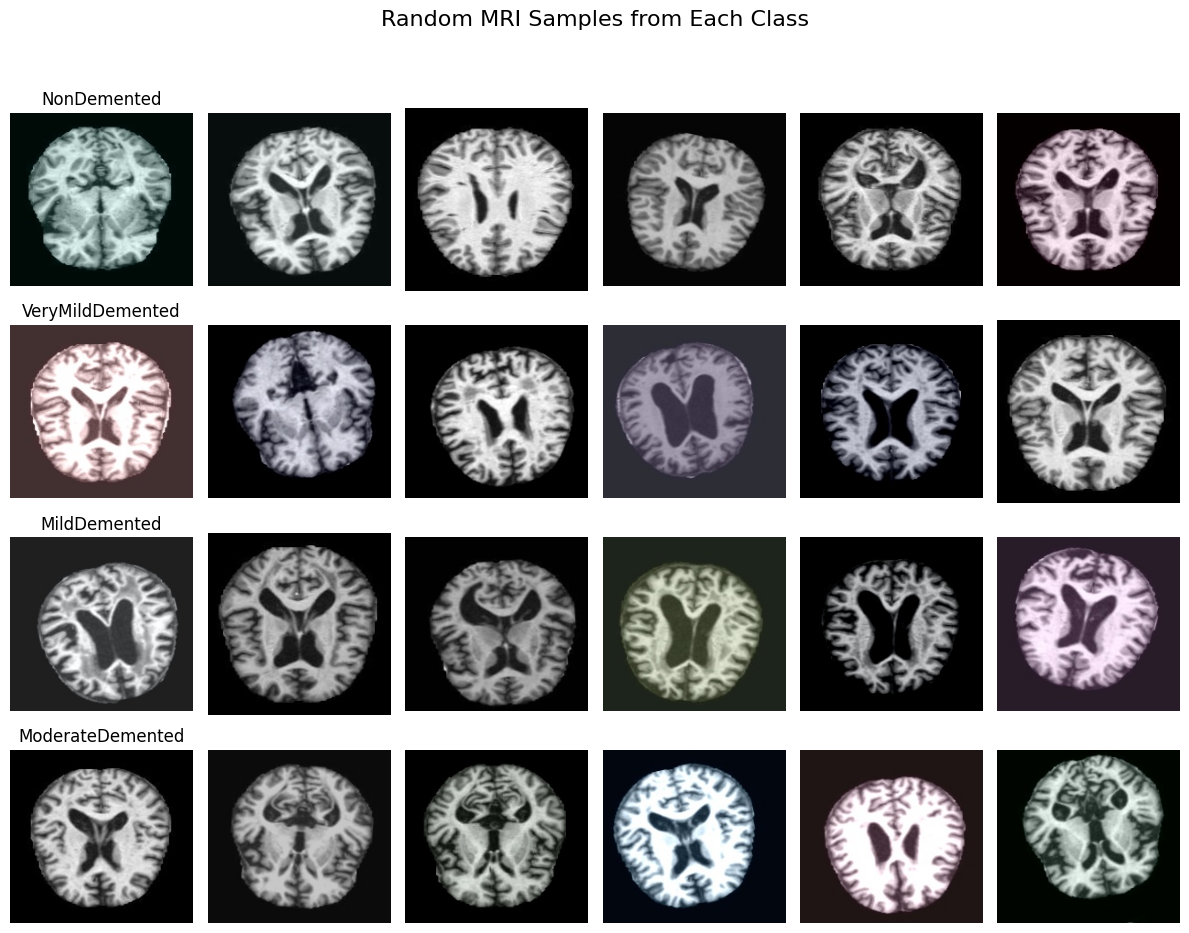

In [7]:
# Corresponding actual folder names in the dataset

# # Use this folder map for the original dataset
# base_dir = path + '/Train/Train'
# folder_map = {
#     'NonDemented': 'Non Demented',
#     'VeryMildDemented': 'Very MildDemented',
#     'MildDemented': 'Mild Demented/Mild Demented Merge',
#     'ModerateDemented': 'Moderate Demented/Moderate Demented Merge'
# }

# Use this folder map for the augmented dataset
base_dir = 'data_split_trainTestVal/train'
folder_map = {
    'NonDemented': 'NonDemented',
    'VeryMildDemented': 'VeryMildDemented',
    'MildDemented': 'MildDemented',
    'ModerateDemented': 'ModerateDemented'
}

# Set up subplots
fig, axes = plt.subplots(len(class_labels), 6, figsize=(12, 10))
if len(class_labels) == 1:
    axes = np.expand_dims(axes, axis=0)

fig.suptitle('Random MRI Samples from Each Class', fontsize=16)

for row_idx, label in enumerate(class_labels):
    folder_name = folder_map[label]
    class_path = os.path.join(base_dir, folder_name)

    if not os.path.exists(class_path):
        print(f"Directory not found for: {folder_name}")
        continue

    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if len(image_files) == 0:
        print(f"No images found in folder: {folder_name}")
        continue

    # Safe sampling (with replacement if fewer than 6)
    sampled_files = random.choices(image_files, k=min(6, len(image_files)))

    for col_idx in range(6):
        ax = axes[row_idx, col_idx]
        ax.axis('off')

        if col_idx < len(sampled_files):
            img_path = os.path.join(class_path, sampled_files[col_idx])
            image = mpimg.imread(img_path)
            ax.imshow(image, cmap='gray')
            if col_idx == 0:
                ax.set_title(label)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [8]:
# Check the class indices for each generator
train_class_indices = train_generator.class_indices
# val_class_indices = val_generator.class_indices
test_class_indices = test_generator.class_indices

# Print the class indices
print("Train Class indices:", train_class_indices)
# print("Validation Class indices:", val_class_indices)
print("Test Class indices:", test_class_indices)

# Check color space
print(train_generator.image_shape)  # should be (240, 240, 3)

Train Class indices: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}
Test Class indices: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}
(240, 240, 3)


## Load the Model and History files

In [9]:
# Load the model
model = load_model('saved_models/dementia_cnn_sequential_model_V10.keras')

In [10]:
# Load the pickle file into history
import pickle

with open('saved_models/dementia_cnn_sequential_history_V10.pkl', 'rb') as f:
    history_dict = pickle.load(f)

class History:
    def __init__(self, history):
        self.history = history

history = History(history_dict)

### Run the Model on Test data

In [11]:
%%time
# Evaluation on Test Set
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.2f}")

# Predictions   
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

/opt/anaconda3/envs/dev/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/opt/anaconda3/envs/dev/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 71s 334ms/step - accuracy: 0.7328 - loss: 17.8671
Test Accuracy: 0.49
213/213 ━━━━━━━━━━━━━━━━━━━━ 84s 395ms/step
CPU times: user 11min 30s, sys: 1min 1s, total: 12min 32s
Wall time: 2min 35s


### Analysis of Results

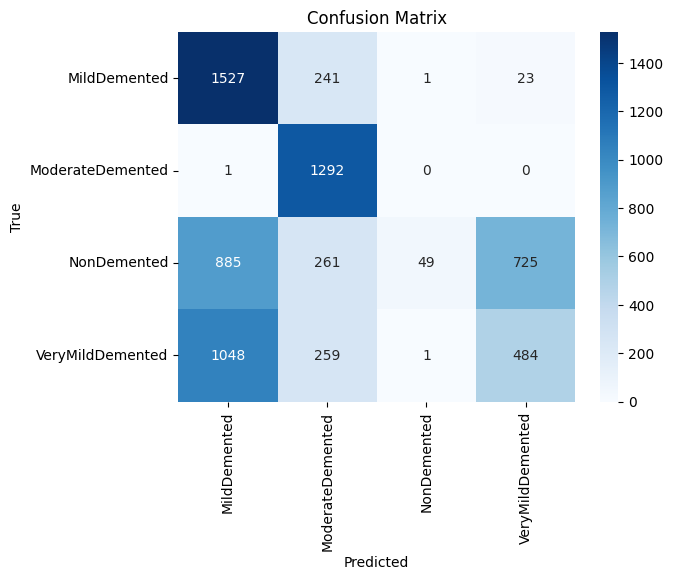

                  precision    recall  f1-score   support

    MildDemented       0.44      0.85      0.58      1792
ModerateDemented       0.63      1.00      0.77      1293
     NonDemented       0.96      0.03      0.05      1920
VeryMildDemented       0.39      0.27      0.32      1792

        accuracy                           0.49      6797
       macro avg       0.61      0.54      0.43      6797
    weighted avg       0.61      0.49      0.40      6797



In [12]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Get class labels in correct order
labels_sorted = sorted(test_generator.class_indices, key=test_generator.class_indices.get)

# Show classification report
print(classification_report(y_true, y_pred_classes, target_names=labels_sorted))

In [13]:
# Print the number of images in each class - non and very mild are weighing the dataset down. 
import collections
print(collections.Counter(test_generator.classes))

Counter({np.int32(2): 1920, np.int32(0): 1792, np.int32(3): 1792, np.int32(1): 1293})


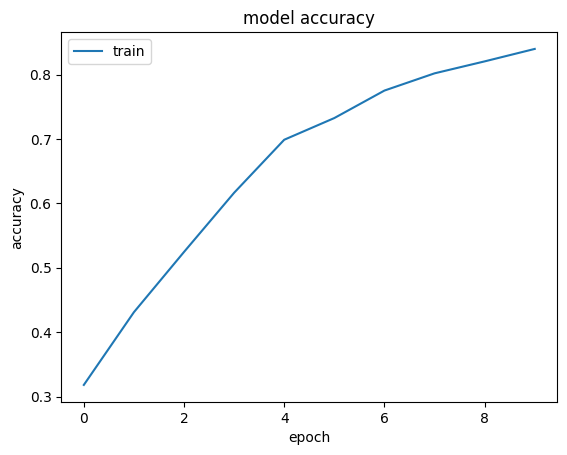

In [93]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

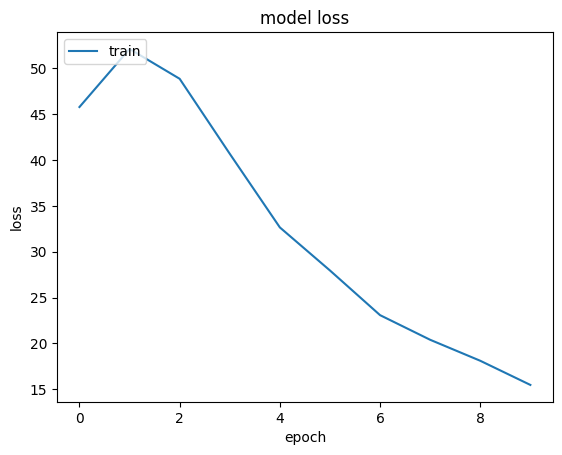

In [18]:
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predict on a Single Image

In [87]:
# Define function to predict on a single image
def predict_single_image_with_plot(image_path, model, target_size=(240, 240), class_indices=None):
    # Load and preprocess the image
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)[0]  # Get softmax array
    predicted_class_index = np.argmax(prediction)

    # Prepare label mapping
    if class_indices:
        class_labels = dict((v, k) for k, v in class_indices.items())
        class_names = [class_labels[i] for i in range(len(class_labels))]
    else:
        class_names = [str(i) for i in range(len(prediction))]

    predicted_label = class_names[predicted_class_index]

    # Plot the image
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')

    # Plot softmax probabilities
    plt.subplot(1, 2, 2)
    bars = plt.bar(class_names, prediction)
    bars[predicted_class_index].set_color('orange')
    plt.title("Softmax Output (Confidence per Class)")
    plt.ylabel("Probability")
    plt.ylim([0, 1])
    plt.xticks(rotation=15)

    plt.tight_layout()
    plt.show()

    return predicted_label

In [88]:
# Set class indices for the test generator
class_indices = test_generator.class_indices

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


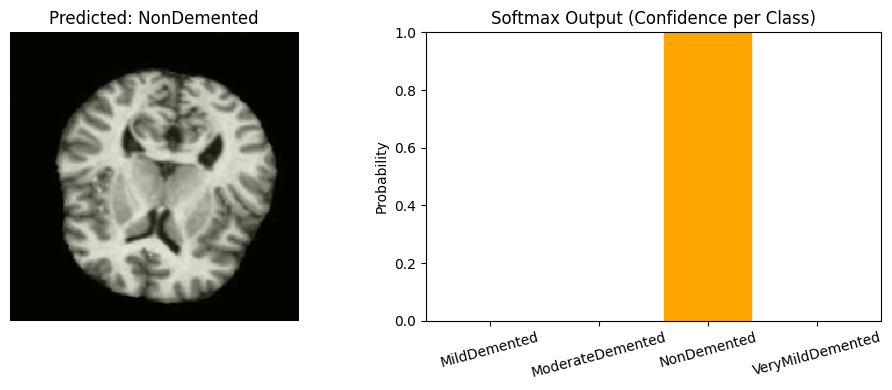

'NonDemented'

In [91]:
# predict on a single image (NonDemented)
image_path = "data_split_trainTest/test/NonDemented/0b94d95b-1b31-47c3-a492-7c9410a3aca1.jpg"
predict_single_image_with_plot(image_path, model, class_indices=class_indices)


In [82]:
# Get predicted class indices
predicted_class_indices = np.argmax(y_pred, axis=1)

# Get the reverse class mapping
class_indices = test_generator.class_indices
inv_class_indices = dict((v, k) for k, v in class_indices.items())
predicted_labels = [inv_class_indices[i] for i in predicted_class_indices]

# Get filenames from the generator
filenames = test_generator.filenames

# Create DataFrame
results_df = pd.DataFrame({
    "filename": filenames,
    "predicted_label": predicted_labels
})

# Display first few results
results_df.head(100)


,filename,predicted_label
0,MildDemented/000cdcc4-3e54-4034-a538-203c8047b...,MildDemented
1,MildDemented/0013ad52-8398-4892-9fde-060eb1ae9...,MildDemented
2,MildDemented/00be34e4-c61c-45a8-8ee8-48e29a8ad...,MildDemented
3,MildDemented/00e1264f-15c3-43f9-9f13-4865e1ec3...,MildDemented
4,MildDemented/00f17d34-5e30-44a2-ad3e-296a70f76...,MildDemented
...,...,...
95,MildDemented/0df6a779-1a4d-44b6-91eb-65e7ce869...,MildDemented
96,MildDemented/0e4c7d2e-d561-4cac-a8bc-bc592c286...,VeryMildDemented
97,MildDemented/0e8c634e-3d8c-4664-99bb-0701afe34...,MildDemented
98,MildDemented/0e9af5ee-d168-4eb8-a8b7-eebf8b462...,MildDemented


In [84]:
results_df[results_df["predicted_label"] == "VeryMildDemented"]

,filename,predicted_label
62,MildDemented/09bd5a95-4ea0-4449-a6af-6f8590388...,VeryMildDemented
96,MildDemented/0e4c7d2e-d561-4cac-a8bc-bc592c286...,VeryMildDemented
241,MildDemented/206bf797-b14c-4a6f-b06c-012a03b3c...,VeryMildDemented
341,MildDemented/306bd464-f37b-4040-9a8b-6f176ce83...,VeryMildDemented
362,MildDemented/32f64711-add2-4676-9031-b75256823...,VeryMildDemented
...,...,...
6765,VeryMildDemented/fbfdf4ff-53e6-4d04-9664-79c74...,VeryMildDemented
6771,VeryMildDemented/fce87642-b888-4d0b-979a-362f5...,VeryMildDemented
6773,VeryMildDemented/fcf84a3b-93b4-405c-a113-efbd0...,VeryMildDemented
6774,VeryMildDemented/fcfad237-ab2b-443a-9b6f-6f608...,VeryMildDemented
